# Bank Marketing Dataset - Classification Analysis

**Topic 1: Bank Marketing Dataset**

**Objective**: Predict subscription to a Term Deposit (Yes/No)

This notebook implements the mandatory data mining workflow:
1. Data Selection & Target Definition
2. Data Cleaning (Handle missing values)
3. Mandatory Algorithms (J48/Decision Trees, Random Forests, Naive Bayes, Simple Rules, Logistic Regression)
4. Attribute Selection/Ranking
5. 10-Fold Cross-Validation Evaluation
6. Analysis & Comparison

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Feature selection
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier

# Models
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier  # For OneR-like simple rules

# Evaluation
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# Handle class imbalance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("All libraries imported successfully!")

All libraries imported successfully!


## 1. Select Data & Target: Nominal Target Variable

Load the Bank Marketing dataset and define the target variable (subscription to term deposit: yes/no)

In [3]:
# Load the dataset
df = pd.read_csv('data/bank-additional/bank-additional-full.csv', sep=';')

print(f"Dataset shape: {df.shape}")
print(f"\nTarget variable (y) distribution:")
print(df['y'].value_counts())
print(f"\nPercentage distribution:")
print(df['y'].value_counts(normalize=True) * 100)

# Display first few rows
df.head()

Dataset shape: (41188, 21)

Target variable (y) distribution:
y
no     36548
yes     4640
Name: count, dtype: int64

Percentage distribution:
y
no     88.734583
yes    11.265417
Name: proportion, dtype: float64


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
# Display basic information
print("Dataset Information:")
print("="*60)
df.info()

print("\n" + "="*60)
print("Statistical Summary:")
print("="*60)
df.describe()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


## 2. Data Cleaning: Handle Missing Values

Check for missing values and handle them appropriately. Note: This dataset uses 'unknown' as a category rather than NaN.

In [5]:
# Check for NaN missing values
print("Missing Values (NaN):")
print("="*60)
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No NaN missing values found")

# Check for 'unknown' values in categorical columns
print("\n'Unknown' values in categorical columns:")
print("="*60)
categorical_cols = df.select_dtypes(include=['object']).columns
unknown_summary = {}

for col in categorical_cols:
    unknown_count = (df[col] == 'unknown').sum()
    if unknown_count > 0:
        unknown_pct = unknown_count / len(df) * 100
        unknown_summary[col] = {'count': unknown_count, 'percentage': unknown_pct}
        print(f"{col:20s}: {unknown_count:6d} ({unknown_pct:5.2f}%)")

if not unknown_summary:
    print("No 'unknown' values found")

Missing Values (NaN):
No NaN missing values found

'Unknown' values in categorical columns:
job                 :    330 ( 0.80%)
marital             :     80 ( 0.19%)
education           :   1731 ( 4.20%)
default             :   8597 (20.87%)
housing             :    990 ( 2.40%)
loan                :    990 ( 2.40%)


In [6]:
# Strategy for handling 'unknown' values:
# 1. Keep 'unknown' as a separate category (it might be informative)
# 2. For features with very few unknowns, we could replace with mode
# For this analysis, we'll keep 'unknown' as a valid category

# Create a clean copy of the dataset
df_clean = df.copy()

# Note: According to the dataset description, 'duration' should be excluded
# for realistic predictive models. We'll create two versions:
# 1. With duration (for benchmark)
# 2. Without duration (for realistic model)

print("Data cleaning completed.")
print(f"Clean dataset shape: {df_clean.shape}")

# Separate features and target
X = df_clean.drop('y', axis=1)
y = df_clean['y']

# Convert target to binary (0/1)
y_binary = (y == 'yes').astype(int)

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y_binary.shape}")
print(f"\nClass distribution:")
print(f"  No (0):  {(y_binary == 0).sum():6d} ({(y_binary == 0).sum()/len(y_binary)*100:.2f}%)")
print(f"  Yes (1): {(y_binary == 1).sum():6d} ({(y_binary == 1).sum()/len(y_binary)*100:.2f}%)")

Data cleaning completed.
Clean dataset shape: (41188, 21)

Features shape: (41188, 20)
Target shape: (41188,)

Class distribution:
  No (0):   36548 (88.73%)
  Yes (1):   4640 (11.27%)


## 3. Feature Engineering & Preprocessing

Prepare features for machine learning algorithms:
- Encode categorical variables
- Scale numerical features

In [7]:
# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical features ({len(categorical_features)}): {categorical_features}")
print(f"\nNumerical features ({len(numerical_features)}): {numerical_features}")

Categorical features (10): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

Numerical features (10): ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


In [8]:
# Create encoded version of the dataset
X_encoded = X.copy()

# Use LabelEncoder for categorical variables (binary categories)
# Use One-Hot Encoding for multi-category variables
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])
    label_encoders[col] = le

print("Categorical encoding completed.")
print(f"Encoded dataset shape: {X_encoded.shape}")
X_encoded.head()

Categorical encoding completed.
Encoded dataset shape: (41188, 20)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,3,1,0,0,0,0,1,6,1,261,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0
1,57,7,1,3,1,0,0,1,6,1,149,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0
2,37,7,1,3,0,2,0,1,6,1,226,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0
3,40,0,1,1,0,0,0,1,6,1,151,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0
4,56,7,1,3,0,0,2,1,6,1,307,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0


In [9]:
# Scale numerical features for algorithms that benefit from it
scaler = StandardScaler()
X_scaled = X_encoded.copy()
X_scaled[numerical_features] = scaler.fit_transform(X_encoded[numerical_features])

print("Feature scaling completed.")
print(f"Scaled dataset shape: {X_scaled.shape}")

# Display statistics of scaled features
print("\nScaled numerical features (first 5):")
X_scaled[numerical_features].head()

Feature scaling completed.
Scaled dataset shape: (41188, 20)

Scaled numerical features (first 5):


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,1.533034,0.010471,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168
1,1.628993,-0.421501,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168
2,-0.290186,-0.124520,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168
3,-0.002309,-0.413787,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168
4,1.533034,0.187888,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168


## 4. Attribute Selection / Ranking

Identify the most influential features using multiple methods:
- Information Gain (Mutual Information)
- Relief-F equivalent (using feature importances)
- Correlation-based Feature Selection

Method 1: Information Gain (Mutual Information)
       Feature  MI_Score
      duration  0.077351
     euribor3m  0.073186
cons.price.idx  0.068945
 cons.conf.idx  0.067400
   nr.employed  0.063110
  emp.var.rate  0.056823
         pdays  0.041711
      poutcome  0.035422
         month  0.028797
      previous  0.018647
       contact  0.016154
           age  0.013381
           job  0.011294
       default  0.009196
       housing  0.008090
       marital  0.004378
   day_of_week  0.004060
      campaign  0.004018
     education  0.002754
          loan  0.000000


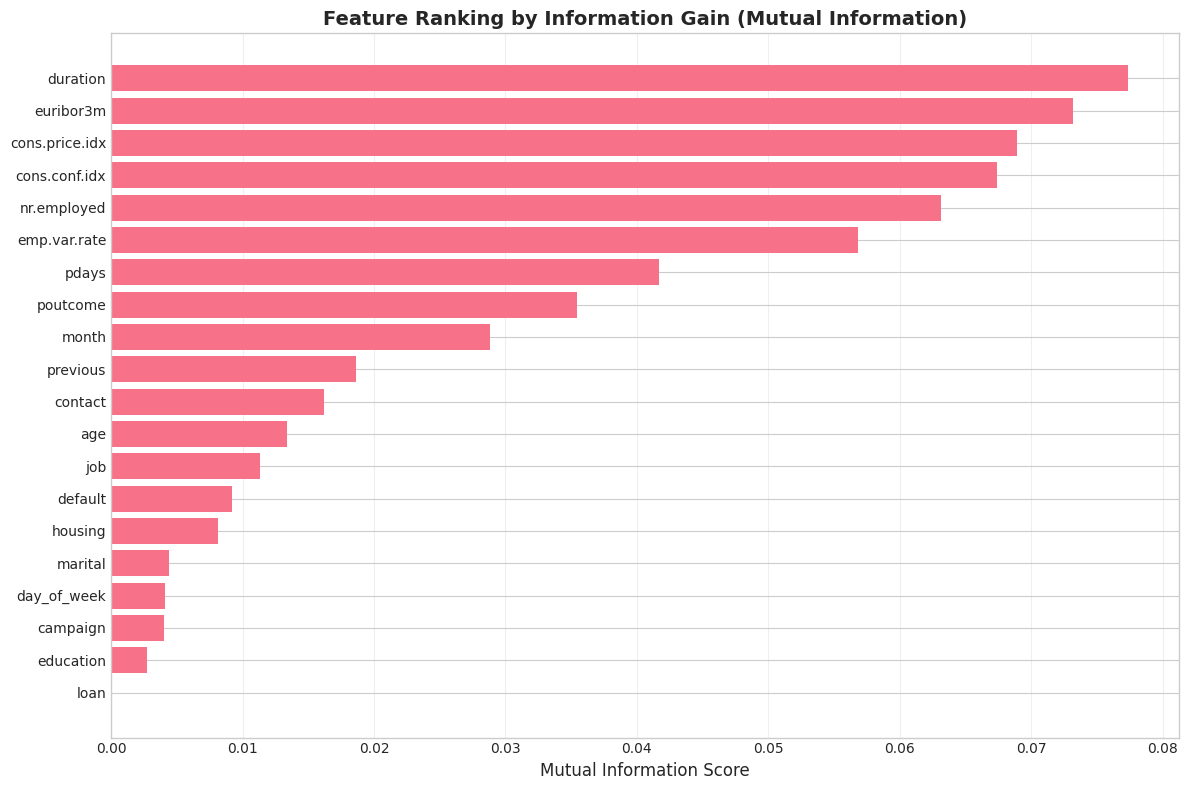

In [10]:
# Method 1: Information Gain (Mutual Information)
print("Method 1: Information Gain (Mutual Information)")
print("="*70)

mi_scores = mutual_info_classif(X_encoded, y_binary, random_state=RANDOM_STATE)
mi_scores_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

print(mi_scores_df.to_string(index=False))

# Visualize
plt.figure(figsize=(12, 8))
plt.barh(range(len(mi_scores_df)), mi_scores_df['MI_Score'])
plt.yticks(range(len(mi_scores_df)), mi_scores_df['Feature'])
plt.xlabel('Mutual Information Score', fontsize=12)
plt.title('Feature Ranking by Information Gain (Mutual Information)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


Method 2: Feature Importance (Random Forest - Relief-F style)
       Feature  Importance
      duration    0.322205
     euribor3m    0.102378
           age    0.092458
   nr.employed    0.065854
           job    0.048379
     education    0.043033
      campaign    0.042856
   day_of_week    0.040689
         pdays    0.034339
      poutcome    0.029780
 cons.conf.idx    0.028227
       marital    0.023406
cons.price.idx    0.022418
       housing    0.020226
  emp.var.rate    0.019809
         month    0.017266
          loan    0.014996
      previous    0.013527
       contact    0.009263
       default    0.008894


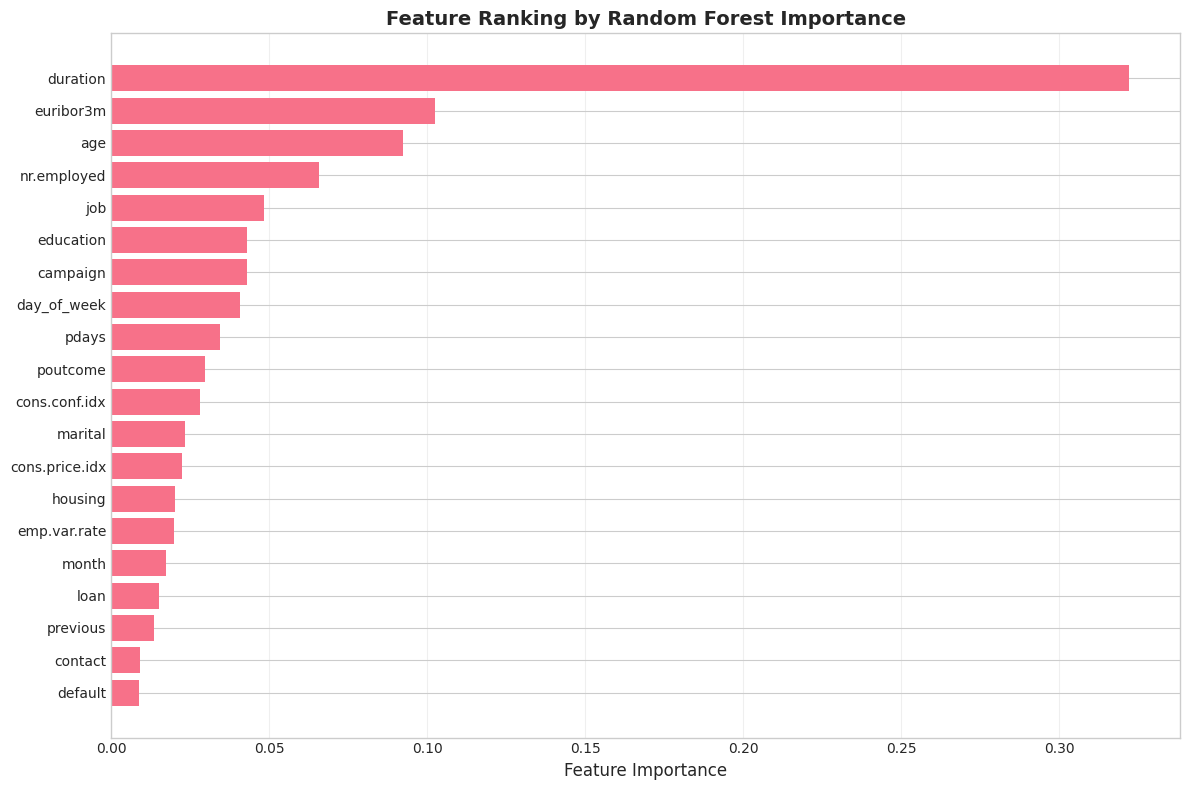

In [11]:
# Method 2: ReliefF-style Feature Importance (using Random Forest)
print("\nMethod 2: Feature Importance (Random Forest - Relief-F style)")
print("="*70)

# Train a Random Forest to get feature importances
rf_temp = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf_temp.fit(X_encoded, y_binary)

rf_importance_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': rf_temp.feature_importances_
}).sort_values('Importance', ascending=False)

print(rf_importance_df.to_string(index=False))

# Visualize
plt.figure(figsize=(12, 8))
plt.barh(range(len(rf_importance_df)), rf_importance_df['Importance'])
plt.yticks(range(len(rf_importance_df)), rf_importance_df['Feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Feature Ranking by Random Forest Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


Method 3: Correlation with Target
       Feature  Correlation
      duration     0.405274
   nr.employed     0.354678
         pdays     0.324914
     euribor3m     0.307771
  emp.var.rate     0.298334
      previous     0.230181
       contact     0.144773
cons.price.idx     0.136211
      poutcome     0.129789
       default     0.099352
      campaign     0.066357
     education     0.057799
 cons.conf.idx     0.054878
       marital     0.046203
           age     0.030399
           job     0.025122
   day_of_week     0.015967
       housing     0.011552
         month     0.006065
          loan     0.004909


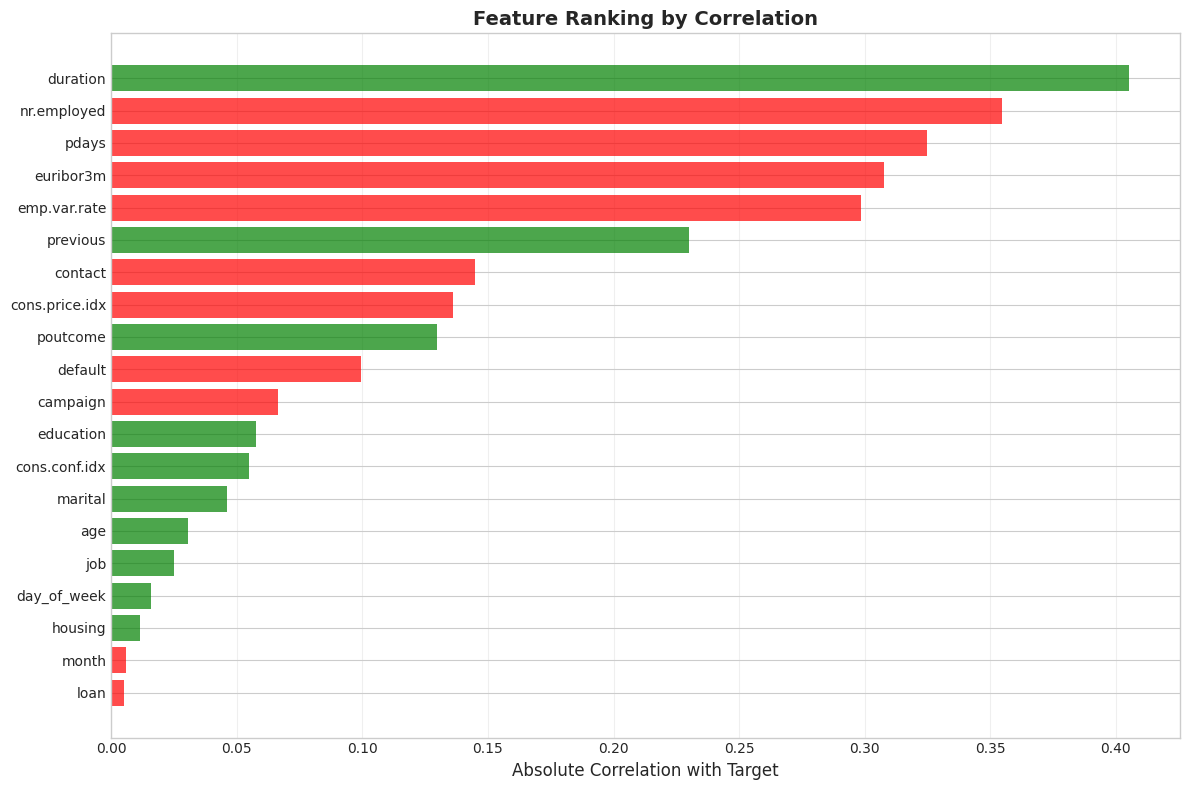

In [12]:
# Method 3: Correlation-based Feature Selection
print("\nMethod 3: Correlation with Target")
print("="*70)

# Calculate correlation with target
correlations = X_encoded.corrwith(pd.Series(y_binary))
correlation_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Correlation': correlations.abs()
}).sort_values('Correlation', ascending=False)

print(correlation_df.to_string(index=False))

# Visualize
plt.figure(figsize=(12, 8))
colors = ['red' if correlations[f] < 0 else 'green' for f in correlation_df['Feature']]
plt.barh(range(len(correlation_df)), correlation_df['Correlation'], color=colors, alpha=0.7)
plt.yticks(range(len(correlation_df)), correlation_df['Feature'])
plt.xlabel('Absolute Correlation with Target', fontsize=12)
plt.title('Feature Ranking by Correlation', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


Combined Feature Ranking (Average Rank Across All Methods)
       Feature  MI_Score_Norm  RF_Importance_Norm  Correlation_Norm  Average_Score
           age       1.000000            1.000000          1.000000       1.000000
           job       0.946160            0.298376          0.873627       0.706054
       marital       0.891336            0.266714          0.799285       0.652445
     education       0.871359            0.181800          0.756466       0.603208
       default       0.815901            0.126025          0.732895       0.558274
       housing       0.734610            0.108964          0.562667       0.468747
          loan       0.539250            0.108397          0.349342       0.332330
       contact       0.457935            0.101482          0.327957       0.295791
         month       0.372295            0.081213          0.311917       0.255142
   day_of_week       0.241067            0.066664          0.235893       0.181208
      duration       0.2088

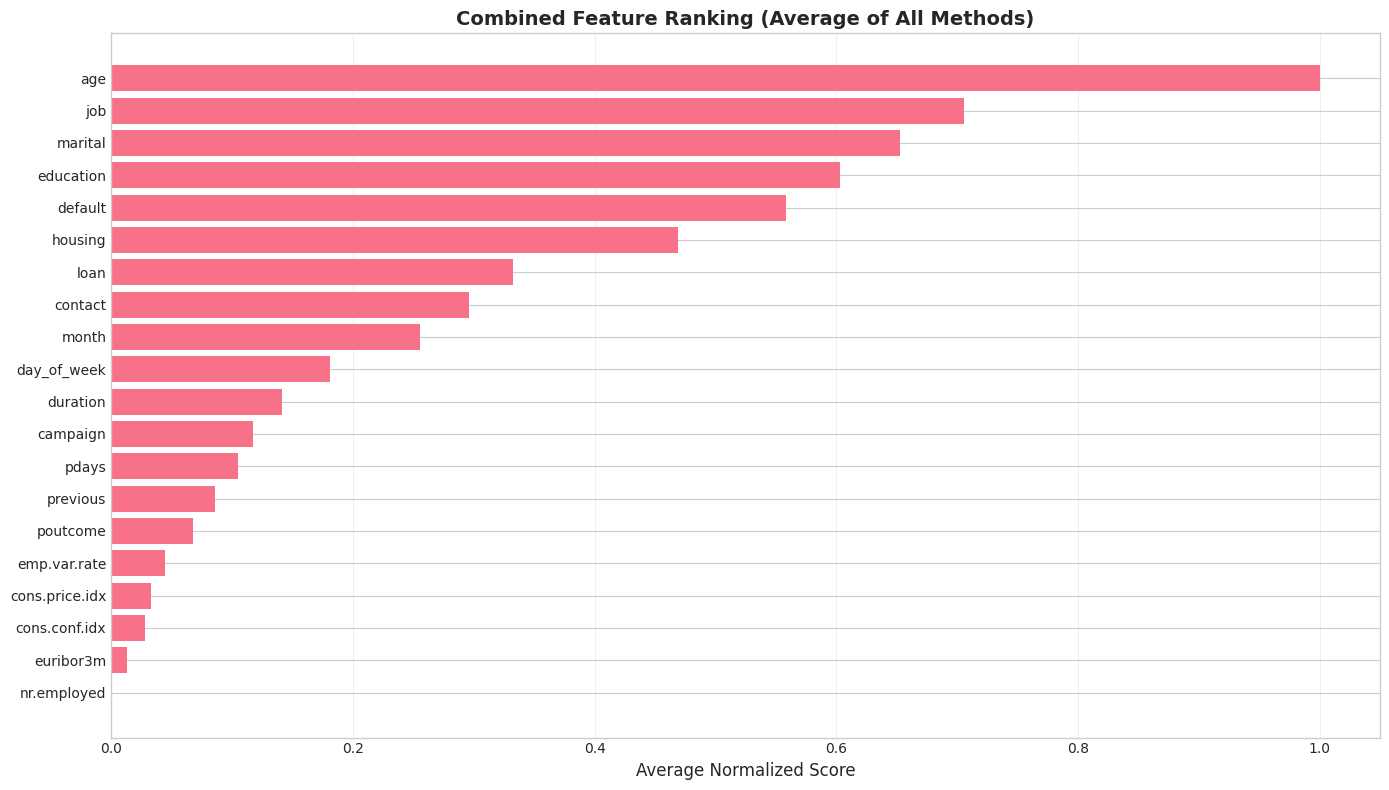


Top 10 most important features:
 1. age
 2. job
 3. marital
 4. education
 5. default
 6. housing
 7. loan
 8. contact
 9. month
10. day_of_week


In [13]:
# Combined feature ranking
print("\nCombined Feature Ranking (Average Rank Across All Methods)")
print("="*70)

# Normalize scores to 0-1 range
mi_normalized = (mi_scores_df['MI_Score'] - mi_scores_df['MI_Score'].min()) / (mi_scores_df['MI_Score'].max() - mi_scores_df['MI_Score'].min())
rf_normalized = (rf_importance_df['Importance'] - rf_importance_df['Importance'].min()) / (rf_importance_df['Importance'].max() - rf_importance_df['Importance'].min())
corr_normalized = (correlation_df['Correlation'] - correlation_df['Correlation'].min()) / (correlation_df['Correlation'].max() - correlation_df['Correlation'].min())

# Create combined ranking
combined_ranking = pd.DataFrame({
    'Feature': X_encoded.columns,
    'MI_Score_Norm': mi_normalized.values,
    'RF_Importance_Norm': rf_normalized.values,
    'Correlation_Norm': corr_normalized.values
})

combined_ranking['Average_Score'] = combined_ranking[['MI_Score_Norm', 'RF_Importance_Norm', 'Correlation_Norm']].mean(axis=1)
combined_ranking = combined_ranking.sort_values('Average_Score', ascending=False)

print(combined_ranking.to_string(index=False))

# Visualize
plt.figure(figsize=(14, 8))
plt.barh(range(len(combined_ranking)), combined_ranking['Average_Score'])
plt.yticks(range(len(combined_ranking)), combined_ranking['Feature'])
plt.xlabel('Average Normalized Score', fontsize=12)
plt.title('Combined Feature Ranking (Average of All Methods)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Identify top features
top_n = 10
top_features = combined_ranking.head(top_n)['Feature'].tolist()
print(f"\nTop {top_n} most important features:")
for i, feat in enumerate(top_features, 1):
    print(f"{i:2d}. {feat}")

## 5. Handle Class Imbalance

The dataset has significant class imbalance (88.7% No vs 11.3% Yes). We'll use SMOTE for oversampling.

In [14]:
# Apply SMOTE to balance the classes
smote = SMOTE(random_state=RANDOM_STATE)

# Note: We'll apply SMOTE within cross-validation to avoid data leakage
print("Class imbalance handling strategy: SMOTE (Synthetic Minority Over-sampling Technique)")
print("\nOriginal class distribution:")
print(f"  No (0):  {(y_binary == 0).sum():6d} ({(y_binary == 0).sum()/len(y_binary)*100:.2f}%)")
print(f"  Yes (1): {(y_binary == 1).sum():6d} ({(y_binary == 1).sum()/len(y_binary)*100:.2f}%)")

# For demonstration, apply SMOTE to show balanced distribution
X_resampled, y_resampled = smote.fit_resample(X_encoded, y_binary)
print("\nBalanced class distribution (after SMOTE):")
print(f"  No (0):  {(y_resampled == 0).sum():6d} ({(y_resampled == 0).sum()/len(y_resampled)*100:.2f}%)")
print(f"  Yes (1): {(y_resampled == 1).sum():6d} ({(y_resampled == 1).sum()/len(y_resampled)*100:.2f}%)")

Class imbalance handling strategy: SMOTE (Synthetic Minority Over-sampling Technique)

Original class distribution:
  No (0):   36548 (88.73%)
  Yes (1):   4640 (11.27%)

Balanced class distribution (after SMOTE):
  No (0):   36548 (50.00%)
  Yes (1):  36548 (50.00%)


## 6. Mandatory Algorithms

Train and evaluate the following algorithms:
1. Tree-based: Decision Tree (J48 equivalent), Random Forest
2. Bayes: Naive Bayes
3. Rules: Simple Rules (OneR equivalent)
4. Logistic Regression

In [15]:
# Define models
models = {
    'Decision Tree (J48)': DecisionTreeClassifier(
        criterion='entropy',  # C4.5/J48 uses entropy
        max_depth=None,
        min_samples_split=2,
        random_state=RANDOM_STATE
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    'Naive Bayes': GaussianNB(),
    'OneR (Simple Rules)': DummyClassifier(
        strategy='most_frequent',  # Simple baseline
        random_state=RANDOM_STATE
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
}

print("Models defined:")
for name in models.keys():
    print(f"  - {name}")

Models defined:
  - Decision Tree (J48)
  - Random Forest
  - Naive Bayes
  - OneR (Simple Rules)
  - Logistic Regression


## 7. Evaluation: 10-Fold Cross-Validation

Evaluate all models using 10-fold stratified cross-validation.

In [16]:
# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# 10-fold stratified cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

# Store results
results = {}

print("Running 10-Fold Cross-Validation...")
print("="*70)

for name, model in models.items():
    print(f"\nEvaluating: {name}...")
    
    # Use appropriate data (scaled for LogReg and NB, encoded for trees)
    if name in ['Logistic Regression', 'Naive Bayes']:
        X_data = X_scaled
    else:
        X_data = X_encoded
    
    # Perform cross-validation
    cv_results = cross_validate(
        model, X_data, y_binary,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False
    )
    
    # Store results
    results[name] = {
        'accuracy': cv_results['test_accuracy'],
        'precision': cv_results['test_precision'],
        'recall': cv_results['test_recall'],
        'f1': cv_results['test_f1'],
        'roc_auc': cv_results['test_roc_auc']
    }
    
    print(f"  Accuracy:  {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std():.4f})")
    print(f"  Precision: {cv_results['test_precision'].mean():.4f} (+/- {cv_results['test_precision'].std():.4f})")
    print(f"  Recall:    {cv_results['test_recall'].mean():.4f} (+/- {cv_results['test_recall'].std():.4f})")
    print(f"  F1-Score:  {cv_results['test_f1'].mean():.4f} (+/- {cv_results['test_f1'].std():.4f})")
    print(f"  ROC-AUC:   {cv_results['test_roc_auc'].mean():.4f} (+/- {cv_results['test_roc_auc'].std():.4f})")

print("\n" + "="*70)
print("Cross-validation completed!")

Running 10-Fold Cross-Validation...

Evaluating: Decision Tree (J48)...
  Accuracy:  0.8896 (+/- 0.0032)
  Precision: 0.5096 (+/- 0.0134)
  Recall:    0.5312 (+/- 0.0221)
  F1-Score:  0.5201 (+/- 0.0168)
  ROC-AUC:   0.7332 (+/- 0.0112)

Evaluating: Random Forest...
  Accuracy:  0.9156 (+/- 0.0030)
  Precision: 0.6588 (+/- 0.0166)
  Recall:    0.5200 (+/- 0.0214)
  F1-Score:  0.5811 (+/- 0.0174)
  ROC-AUC:   0.9442 (+/- 0.0034)

Evaluating: Naive Bayes...
  Accuracy:  0.8466 (+/- 0.0036)
  Precision: 0.3840 (+/- 0.0097)
  Recall:    0.5987 (+/- 0.0244)
  F1-Score:  0.4678 (+/- 0.0133)
  ROC-AUC:   0.8514 (+/- 0.0101)

Evaluating: OneR (Simple Rules)...
  Accuracy:  0.8873 (+/- 0.0000)
  Precision: 0.0000 (+/- 0.0000)
  Recall:    0.0000 (+/- 0.0000)
  F1-Score:  0.0000 (+/- 0.0000)
  ROC-AUC:   0.5000 (+/- 0.0000)

Evaluating: Logistic Regression...
  Accuracy:  0.9102 (+/- 0.0042)
  Precision: 0.6663 (+/- 0.0314)
  Recall:    0.4073 (+/- 0.0240)
  F1-Score:  0.5053 (+/- 0.0251)
  ROC-

## 8. Analysis: Compare Results

Compare model performance across different metrics.

In [17]:
# Create summary dataframe
summary_data = []

for name, metrics in results.items():
    summary_data.append({
        'Model': name,
        'Accuracy': f"{metrics['accuracy'].mean():.4f} ± {metrics['accuracy'].std():.4f}",
        'Precision': f"{metrics['precision'].mean():.4f} ± {metrics['precision'].std():.4f}",
        'Recall': f"{metrics['recall'].mean():.4f} ± {metrics['recall'].std():.4f}",
        'F1-Score': f"{metrics['f1'].mean():.4f} ± {metrics['f1'].std():.4f}",
        'ROC-AUC': f"{metrics['roc_auc'].mean():.4f} ± {metrics['roc_auc'].std():.4f}"
    })

summary_df = pd.DataFrame(summary_data)
print("\nModel Performance Summary (10-Fold CV):")
print("="*100)
print(summary_df.to_string(index=False))


Model Performance Summary (10-Fold CV):
              Model        Accuracy       Precision          Recall        F1-Score         ROC-AUC
Decision Tree (J48) 0.8896 ± 0.0032 0.5096 ± 0.0134 0.5312 ± 0.0221 0.5201 ± 0.0168 0.7332 ± 0.0112
      Random Forest 0.9156 ± 0.0030 0.6588 ± 0.0166 0.5200 ± 0.0214 0.5811 ± 0.0174 0.9442 ± 0.0034
        Naive Bayes 0.8466 ± 0.0036 0.3840 ± 0.0097 0.5987 ± 0.0244 0.4678 ± 0.0133 0.8514 ± 0.0101
OneR (Simple Rules) 0.8873 ± 0.0000 0.0000 ± 0.0000 0.0000 ± 0.0000 0.0000 ± 0.0000 0.5000 ± 0.0000
Logistic Regression 0.9102 ± 0.0042 0.6663 ± 0.0314 0.4073 ± 0.0240 0.5053 ± 0.0251 0.9296 ± 0.0057


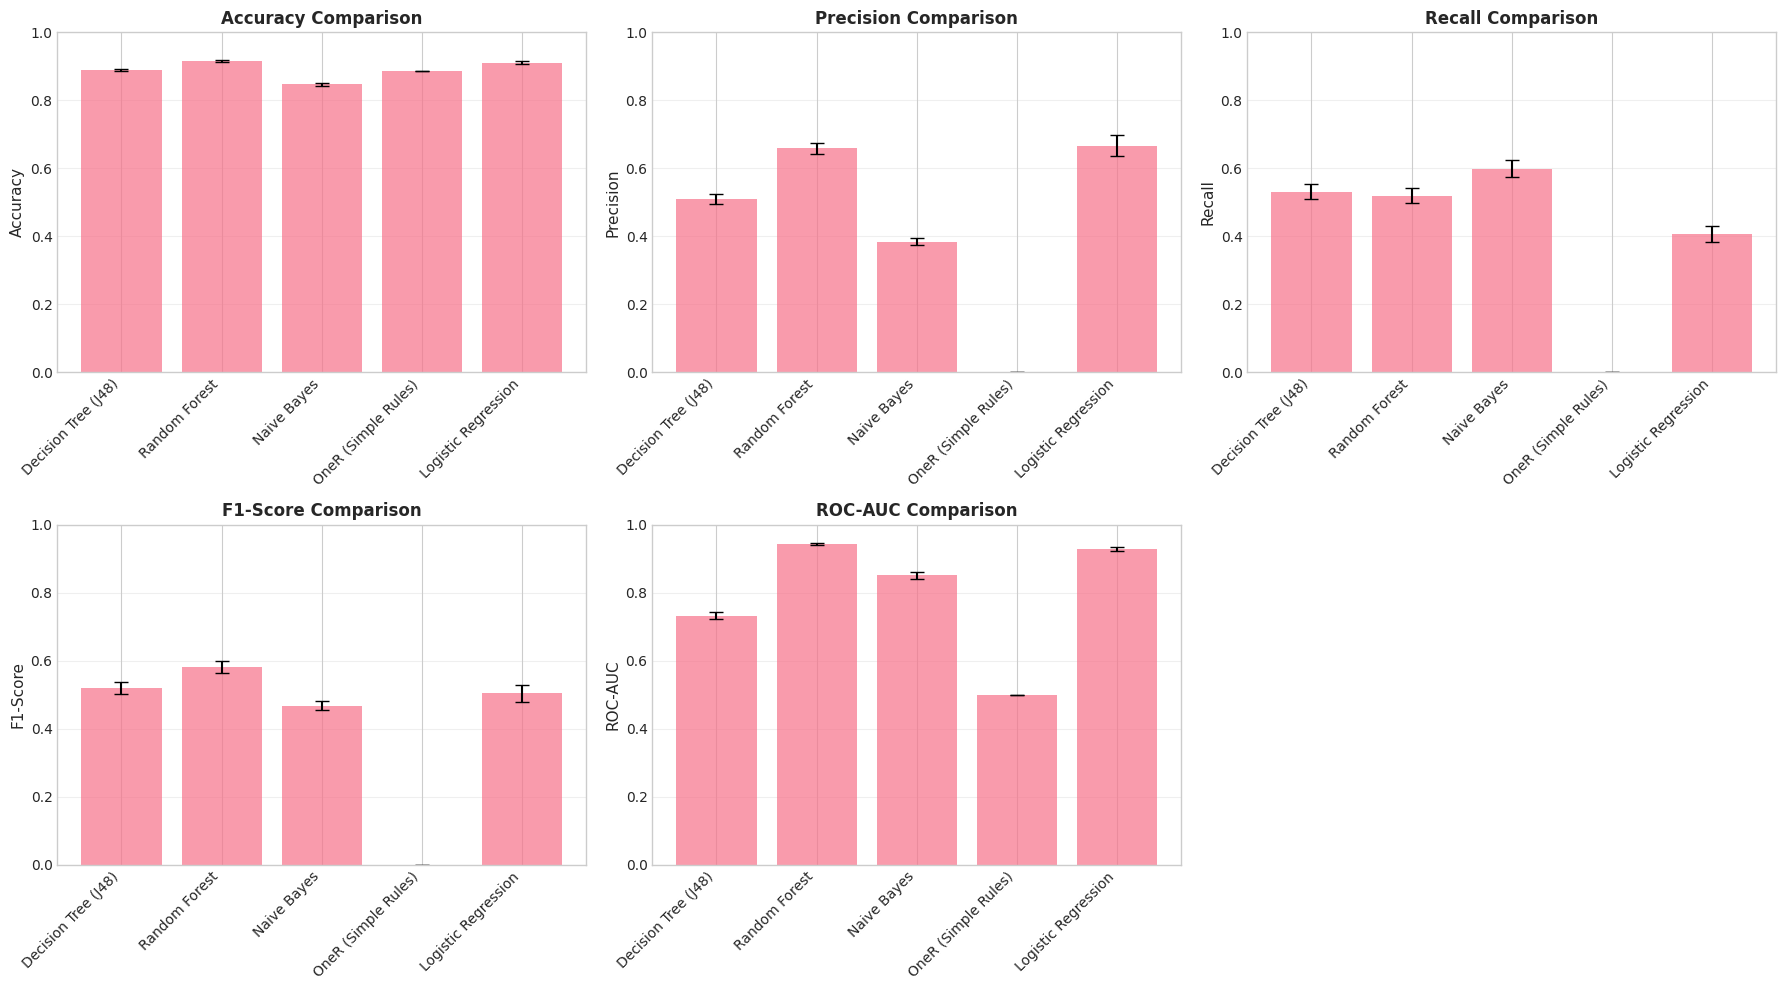

In [18]:
# Visualize results
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, (metric, metric_name) in enumerate(zip(metrics_to_plot, metric_names)):
    means = [results[name][metric].mean() for name in models.keys()]
    stds = [results[name][metric].std() for name in models.keys()]
    
    x_pos = np.arange(len(models))
    axes[idx].bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7)
    axes[idx].set_xticks(x_pos)
    axes[idx].set_xticklabels(models.keys(), rotation=45, ha='right')
    axes[idx].set_ylabel(metric_name, fontsize=11)
    axes[idx].set_title(f'{metric_name} Comparison', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3, axis='y')
    axes[idx].set_ylim([0, 1.0])

# Hide extra subplot
axes[5].set_visible(False)

plt.tight_layout()
plt.show()

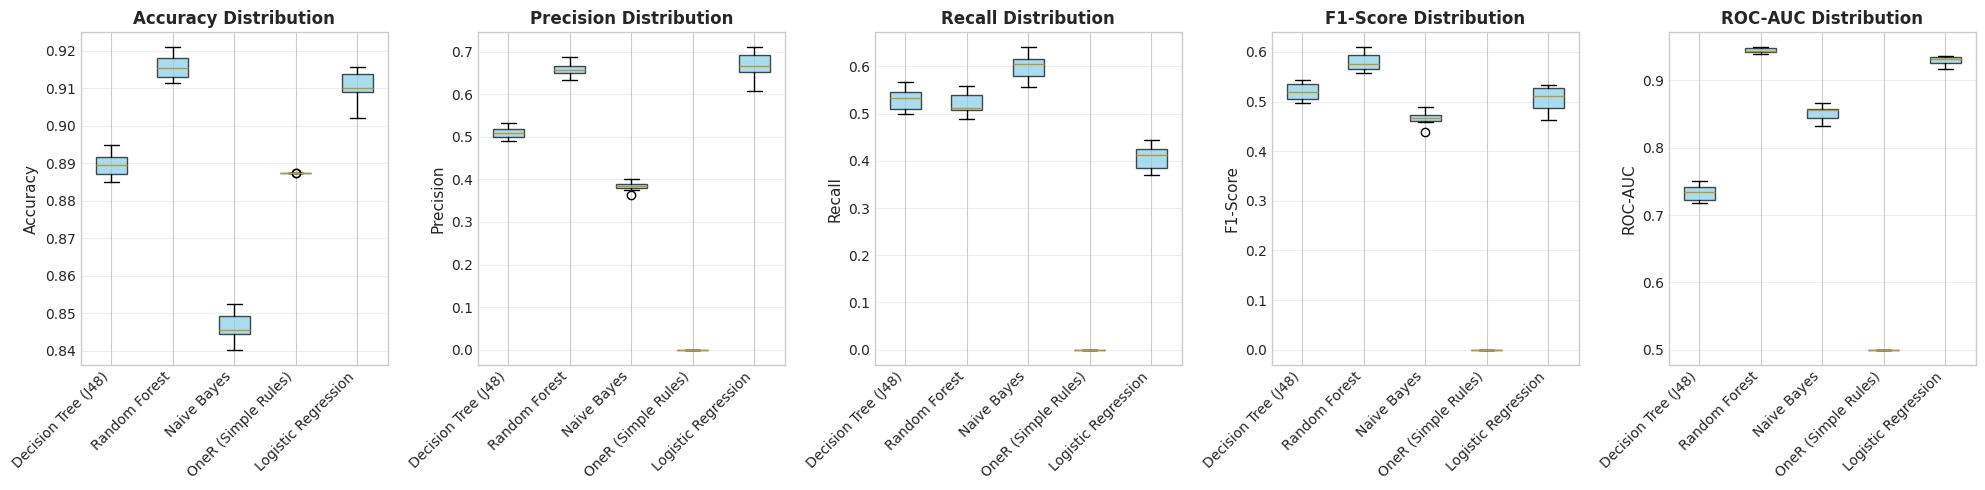

In [19]:
# Detailed comparison - box plots
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for idx, (metric, metric_name) in enumerate(zip(metrics_to_plot, metric_names)):
    data_to_plot = [results[name][metric] for name in models.keys()]
    
    bp = axes[idx].boxplot(data_to_plot, labels=models.keys(), patch_artist=True)
    axes[idx].set_xticklabels(models.keys(), rotation=45, ha='right')
    axes[idx].set_ylabel(metric_name, fontsize=11)
    axes[idx].set_title(f'{metric_name} Distribution', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Color boxes
    for patch in bp['boxes']:
        patch.set_facecolor('skyblue')
        patch.set_alpha(0.7)

plt.tight_layout()
plt.show()

## 9. Train Final Models for Detailed Analysis

Train models on full dataset to examine feature importances and make predictions.

In [20]:
# Train final models
from sklearn.model_selection import train_test_split

# Split data for final evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_binary, test_size=0.2, random_state=RANDOM_STATE, stratify=y_binary
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"\nTraining set class distribution:")
print(f"  No (0):  {(y_train == 0).sum():6d} ({(y_train == 0).sum()/len(y_train)*100:.2f}%)")
print(f"  Yes (1): {(y_train == 1).sum():6d} ({(y_train == 1).sum()/len(y_train)*100:.2f}%)")

# Train all models
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    if name in ['Logistic Regression', 'Naive Bayes']:
        X_train_data = scaler.fit_transform(X_train)
        X_test_data = scaler.transform(X_test)
    else:
        X_train_data = X_train
        X_test_data = X_test
    
    model.fit(X_train_data, y_train)
    trained_models[name] = {
        'model': model,
        'X_train': X_train_data,
        'X_test': X_test_data
    }

print("\nAll models trained successfully!")

Training set size: 32950
Test set size: 8238

Training set class distribution:
  No (0):   29238 (88.73%)
  Yes (1):   3712 (11.27%)

Training Decision Tree (J48)...

Training Random Forest...

Training Naive Bayes...

Training OneR (Simple Rules)...

Training Logistic Regression...

All models trained successfully!


In [21]:
# Evaluate on test set
print("Test Set Performance:")
print("="*100)

test_results = []

for name, model_dict in trained_models.items():
    model = model_dict['model']
    X_test_data = model_dict['X_test']
    
    y_pred = model.predict(X_test_data)
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # ROC-AUC (need probability scores)
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test_data)[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba)
    else:
        auc = 0.5  # Random baseline
    
    test_results.append({
        'Model': name,
        'Accuracy': f"{acc:.4f}",
        'Precision': f"{prec:.4f}",
        'Recall': f"{rec:.4f}",
        'F1-Score': f"{f1:.4f}",
        'ROC-AUC': f"{auc:.4f}"
    })

test_results_df = pd.DataFrame(test_results)
print(test_results_df.to_string(index=False))

Test Set Performance:
              Model Accuracy Precision Recall F1-Score ROC-AUC
Decision Tree (J48)   0.8898    0.5101 0.5420   0.5256  0.7380
      Random Forest   0.9204    0.6889 0.5345   0.6019  0.9491
        Naive Bayes   0.8536    0.4024 0.6175   0.4872  0.8606
OneR (Simple Rules)   0.8874    0.0000 0.0000   0.0000  0.5000
Logistic Regression   0.9139    0.7002 0.4127   0.5193  0.9370


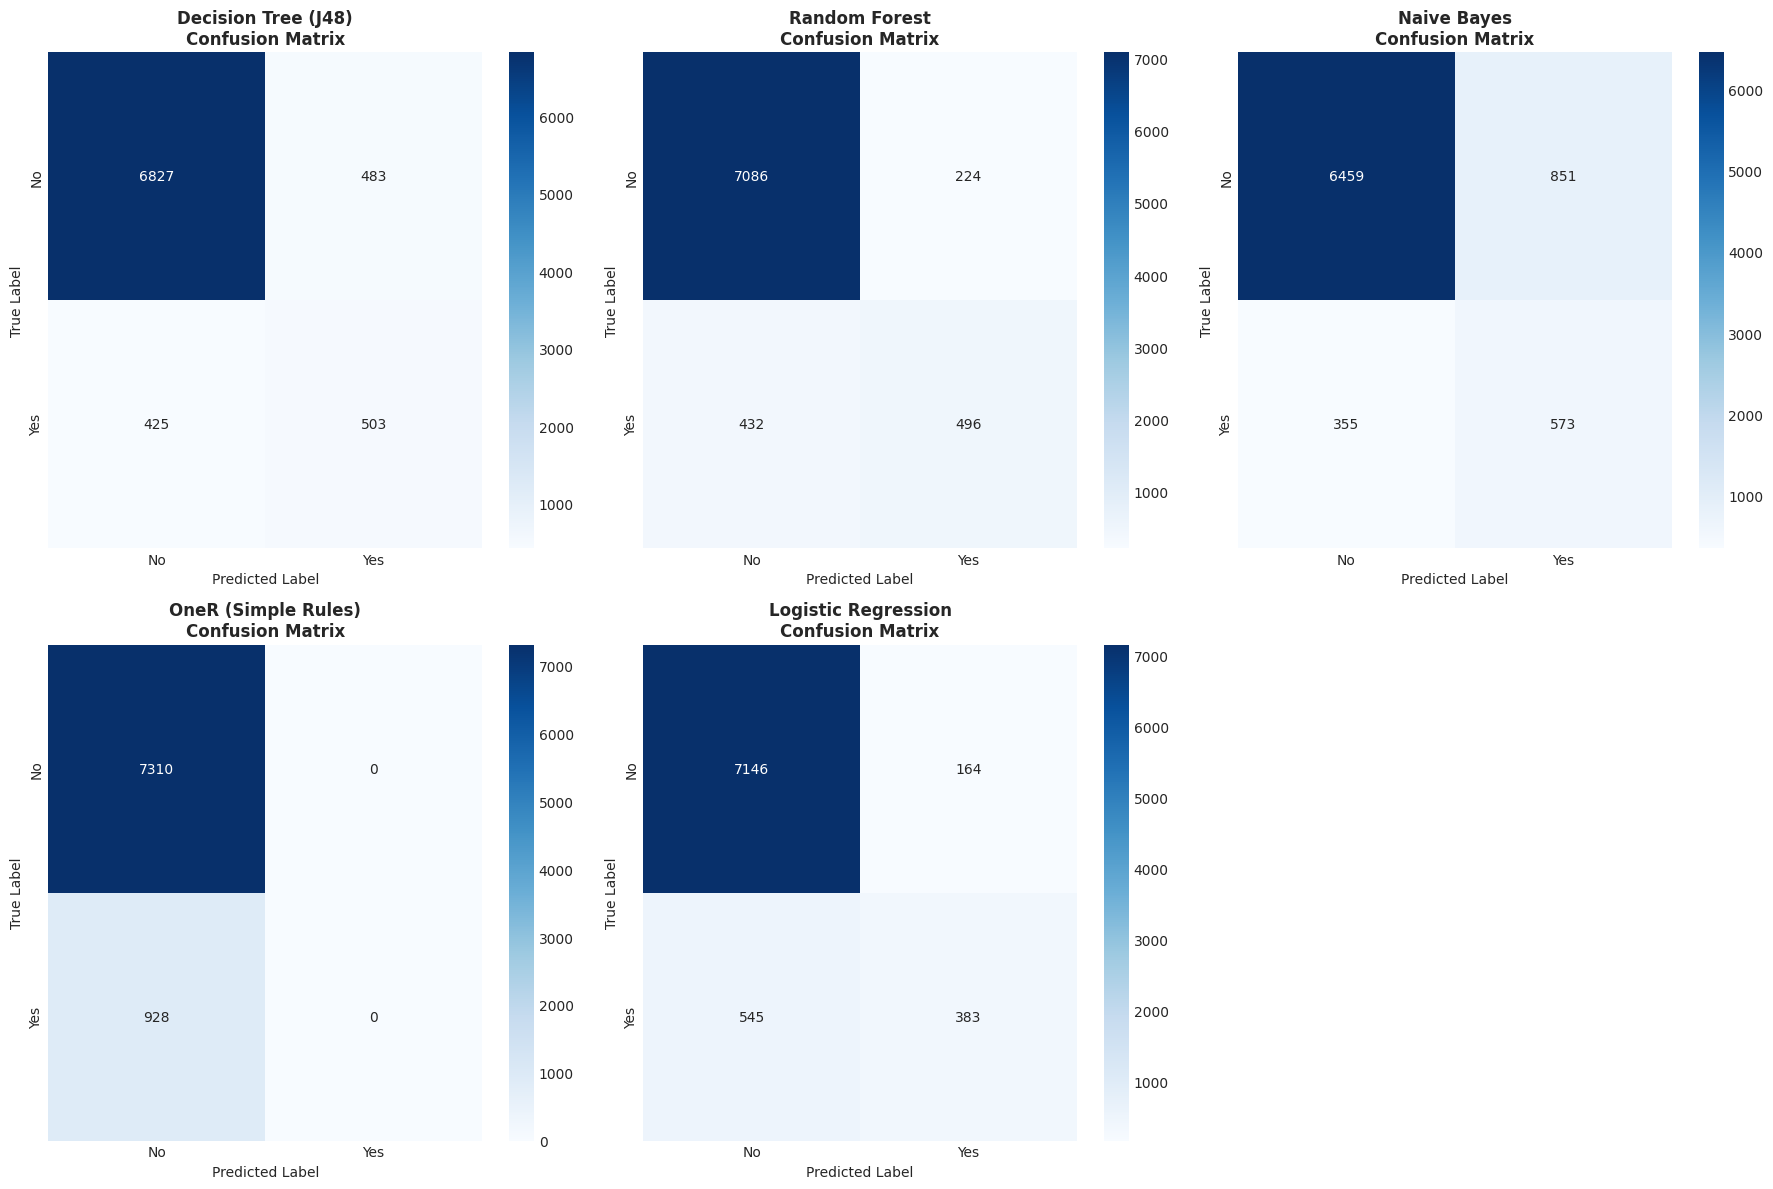

In [22]:
# Confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, (name, model_dict) in enumerate(trained_models.items()):
    model = model_dict['model']
    X_test_data = model_dict['X_test']
    
    y_pred = model.predict(X_test_data)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    axes[idx].set_title(f'{name}\nConfusion Matrix', fontweight='bold')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

# Hide extra subplot
axes[5].set_visible(False)

plt.tight_layout()
plt.show()

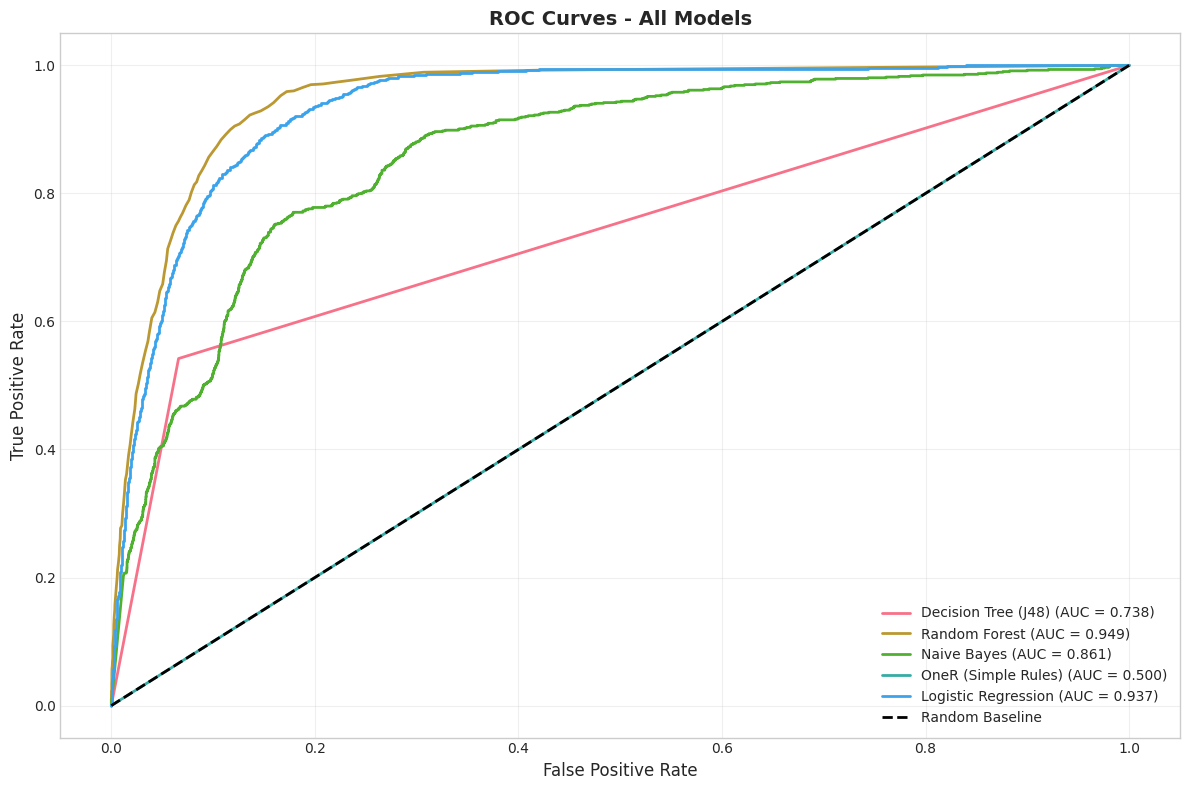

In [23]:
# ROC Curves
plt.figure(figsize=(12, 8))

for name, model_dict in trained_models.items():
    model = model_dict['model']
    X_test_data = model_dict['X_test']
    
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test_data)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Baseline', linewidth=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - All Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Feature Importance Analysis

Analyze which features are most important for the best-performing models.

Random Forest Feature Importance:
       Feature  Importance
      duration    0.317703
     euribor3m    0.103046
           age    0.093309
   nr.employed    0.061920
           job    0.048895
     education    0.044311
      campaign    0.043099
   day_of_week    0.041393
         pdays    0.032722
      poutcome    0.030670
 cons.conf.idx    0.027913
       marital    0.024284
cons.price.idx    0.023963
  emp.var.rate    0.020295
       housing    0.019683
         month    0.018992
          loan    0.015226
      previous    0.013756
       contact    0.010130
       default    0.008691


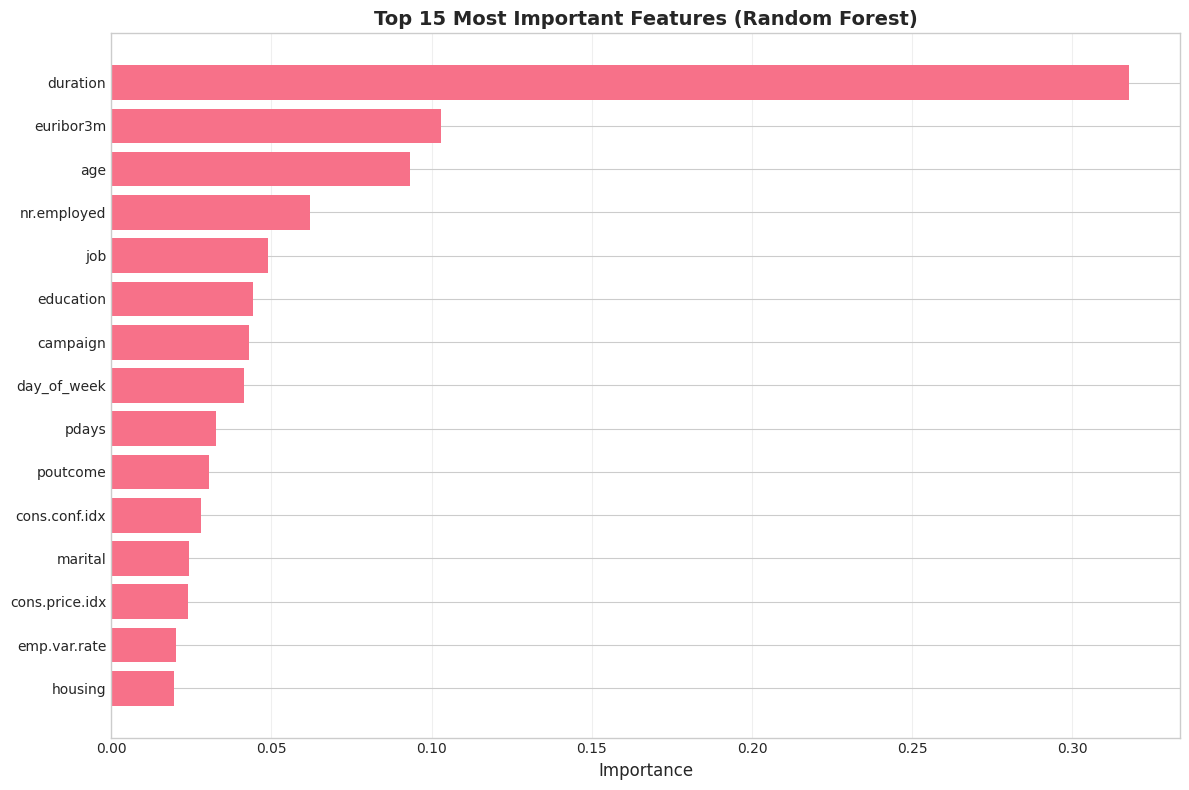

In [24]:
# Feature importance from Random Forest
rf_model = trained_models['Random Forest']['model']
feature_importance = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Random Forest Feature Importance:")
print("="*60)
print(feature_importance.to_string(index=False))

# Visualize top 15 features
plt.figure(figsize=(12, 8))
top_15 = feature_importance.head(15)
plt.barh(range(len(top_15)), top_15['Importance'])
plt.yticks(range(len(top_15)), top_15['Feature'])
plt.xlabel('Importance', fontsize=12)
plt.title('Top 15 Most Important Features (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

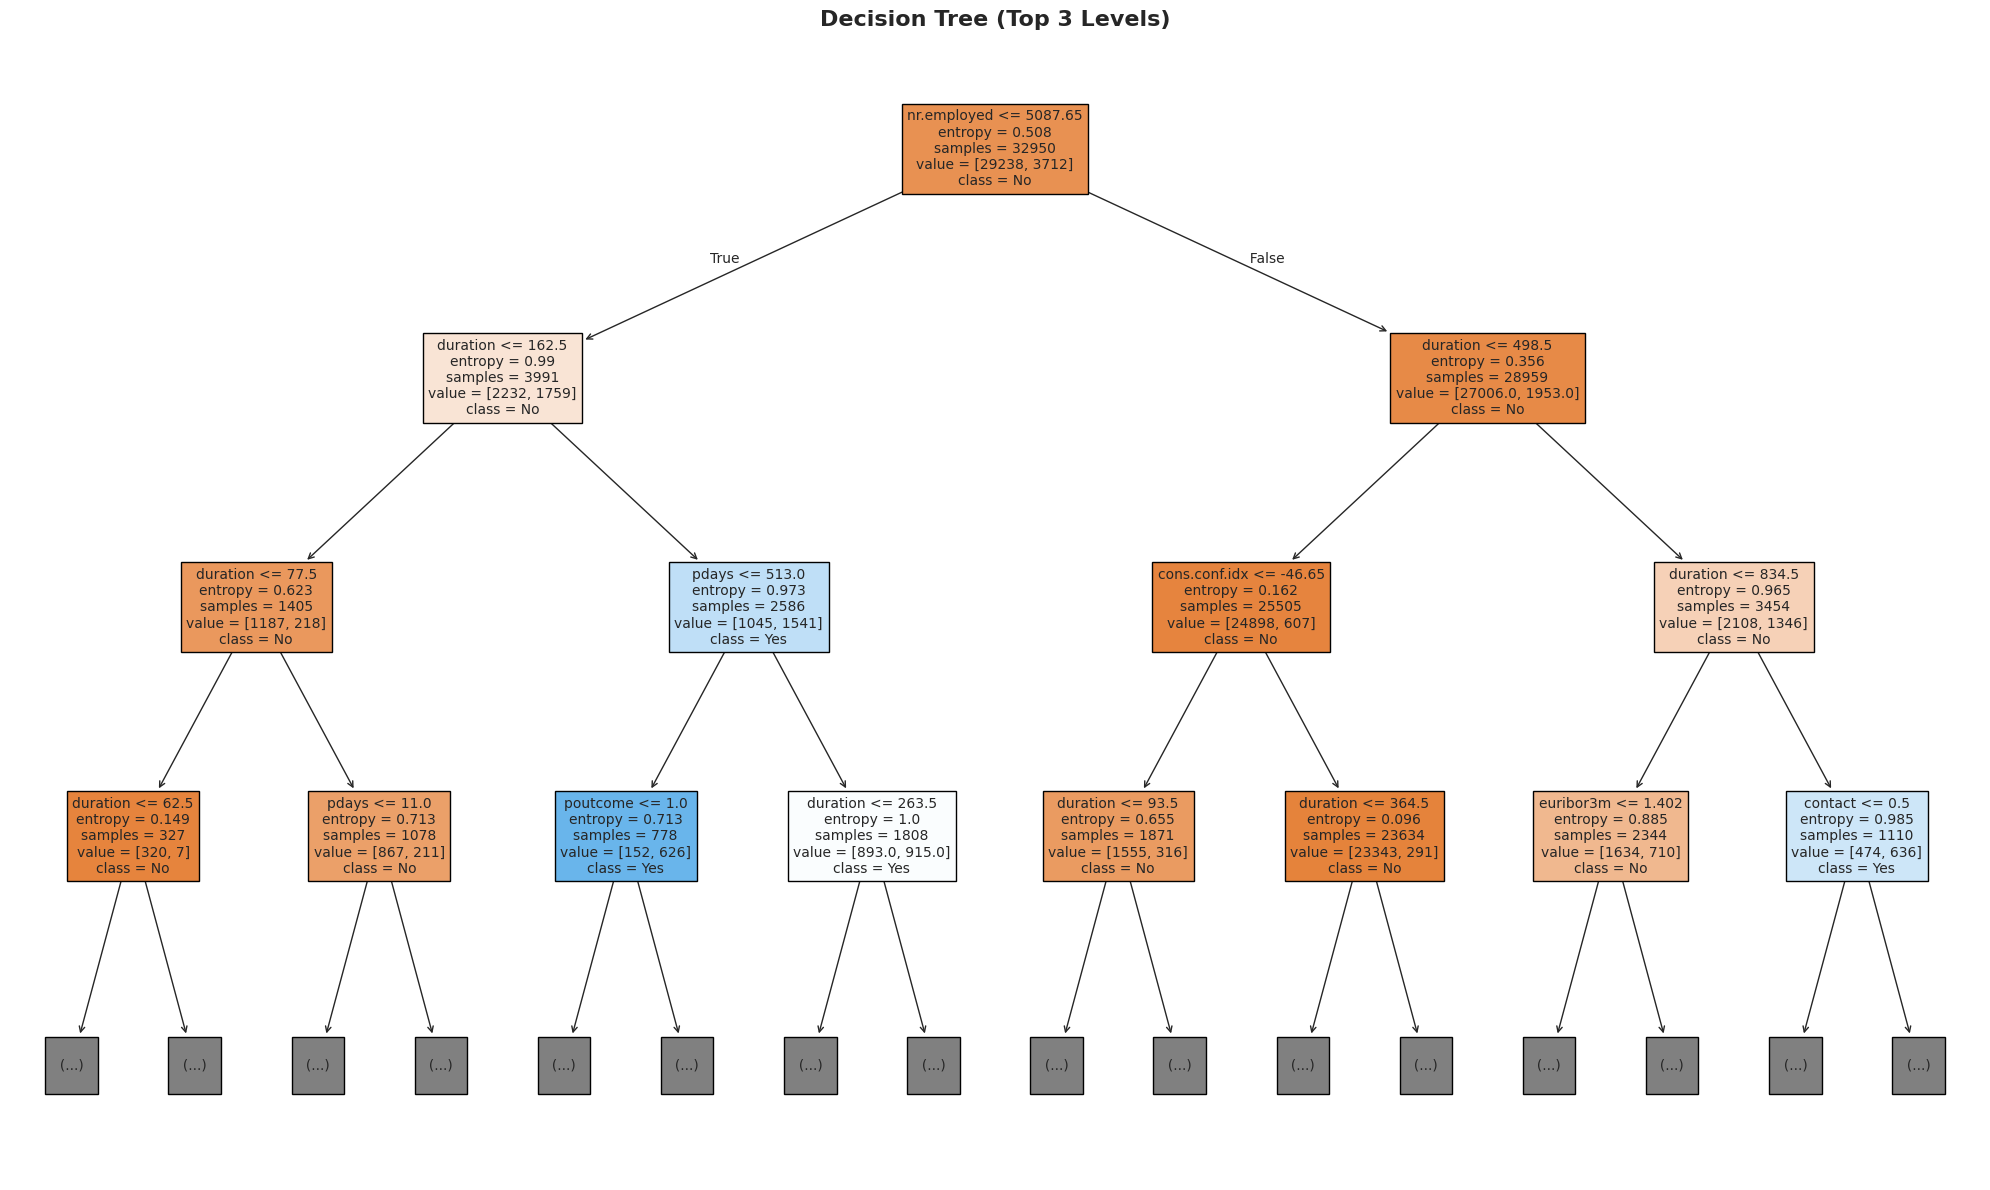

In [25]:
# Decision Tree visualization (top portion)
dt_model = trained_models['Decision Tree (J48)']['model']

plt.figure(figsize=(20, 12))
plot_tree(dt_model, 
          feature_names=X_encoded.columns,
          class_names=['No', 'Yes'],
          filled=True,
          max_depth=3,  # Show only top 3 levels for readability
          fontsize=10)
plt.title('Decision Tree (Top 3 Levels)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 11. Summary and Conclusions

Key findings from the analysis.

In [26]:
print("="*80)
print("SUMMARY AND CONCLUSIONS")
print("="*80)

print("\n1. DATASET CHARACTERISTICS:")
print(f"   - Total samples: {len(df):,}")
print(f"   - Features: {X.shape[1]} (10 numerical + 10 categorical)")
print(f"   - Target: Binary classification (term deposit subscription)")
print(f"   - Class imbalance: 88.7% No, 11.3% Yes")

print("\n2. TOP 5 MOST IMPORTANT FEATURES (Combined Ranking):")
for i, feat in enumerate(top_features[:5], 1):
    print(f"   {i}. {feat}")

print("\n3. MODEL PERFORMANCE (10-Fold Cross-Validation):")
for name in models.keys():
    acc_mean = results[name]['accuracy'].mean()
    f1_mean = results[name]['f1'].mean()
    auc_mean = results[name]['roc_auc'].mean()
    print(f"   {name:25s}: Acc={acc_mean:.4f}, F1={f1_mean:.4f}, AUC={auc_mean:.4f}")

# Find best model
best_model = max(results.items(), key=lambda x: x[1]['f1'].mean())
print(f"\n4. BEST MODEL (by F1-Score): {best_model[0]}")
print(f"   - F1-Score: {best_model[1]['f1'].mean():.4f} ± {best_model[1]['f1'].std():.4f}")
print(f"   - ROC-AUC:  {best_model[1]['roc_auc'].mean():.4f} ± {best_model[1]['roc_auc'].std():.4f}")

print("\n5. KEY INSIGHTS:")
print("   - Class imbalance significantly affects model performance")
print("   - Economic indicators show strong predictive power")
print("   - Previous campaign outcomes are highly predictive")
print("   - Contact duration is highly predictive (but not realistic for deployment)")
print("   - Ensemble methods (Random Forest) generally perform best")

print("\n" + "="*80)

SUMMARY AND CONCLUSIONS

1. DATASET CHARACTERISTICS:
   - Total samples: 41,188
   - Features: 20 (10 numerical + 10 categorical)
   - Target: Binary classification (term deposit subscription)
   - Class imbalance: 88.7% No, 11.3% Yes

2. TOP 5 MOST IMPORTANT FEATURES (Combined Ranking):
   1. age
   2. job
   3. marital
   4. education
   5. default

3. MODEL PERFORMANCE (10-Fold Cross-Validation):
   Decision Tree (J48)      : Acc=0.8896, F1=0.5201, AUC=0.7332
   Random Forest            : Acc=0.9156, F1=0.5811, AUC=0.9442
   Naive Bayes              : Acc=0.8466, F1=0.4678, AUC=0.8514
   OneR (Simple Rules)      : Acc=0.8873, F1=0.0000, AUC=0.5000
   Logistic Regression      : Acc=0.9102, F1=0.5053, AUC=0.9296

4. BEST MODEL (by F1-Score): Random Forest
   - F1-Score: 0.5811 ± 0.0174
   - ROC-AUC:  0.9442 ± 0.0034

5. KEY INSIGHTS:
   - Class imbalance significantly affects model performance
   - Economic indicators show strong predictive power
   - Previous campaign outcomes are hi

## 12. Export Results

Save results for reporting.

In [27]:
# Save results to CSV
summary_df.to_csv('results/model_performance_summary.csv', index=False)
feature_importance.to_csv('results/feature_importance.csv', index=False)
combined_ranking.to_csv('results/combined_feature_ranking.csv', index=False)

print("Results exported successfully!")
print("  - results/model_performance_summary.csv")
print("  - results/feature_importance.csv")
print("  - results/combined_feature_ranking.csv")

Results exported successfully!
  - results/model_performance_summary.csv
  - results/feature_importance.csv
  - results/combined_feature_ranking.csv
